In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import os
%matplotlib inline

In [2]:
def get_sample(seq_length, mu, sigma, rho, start):
    diffs = np.random.normal(mu, sigma, seq_length)
    for i in xrange(1, seq_length):
        diffs[i] += diffs[i - 1] * rho
    return np.random.uniform(-start, start, (1)) + np.cumsum(diffs)

In [3]:
mu_1, sigma_1, rho_1, start_1 = 0.4, 0.5, 0.95, 5000.0
mu_2, sigma_2, rho_2, start_2 = -0.4, 0.75, -0.75, 5000.0
seq_length = 510
batch_size = 16

## We sample time series from two different distributions

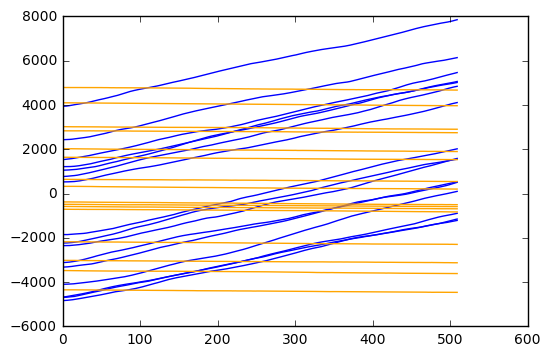

In [4]:
plt.plot(np.arange(seq_length), 
         np.asanyarray([get_sample(seq_length, mu_1, sigma_1, rho_1, start_1) 
                        for _ in xrange(batch_size)]).T,
         c='blue')
plt.plot(np.arange(seq_length), 
         np.asanyarray([get_sample(seq_length, mu_2, sigma_2, rho_2, start_2) 
                        for _ in xrange(batch_size)]).T,
         c='orange')
plt.show()

## Linear separation is only possible after differentiation

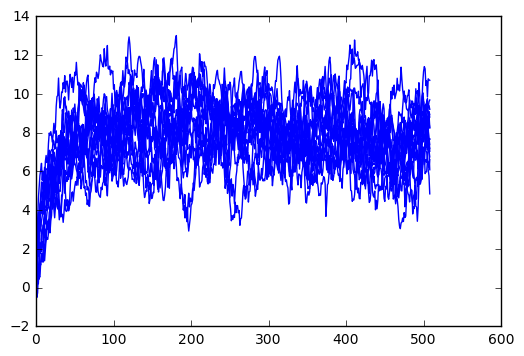

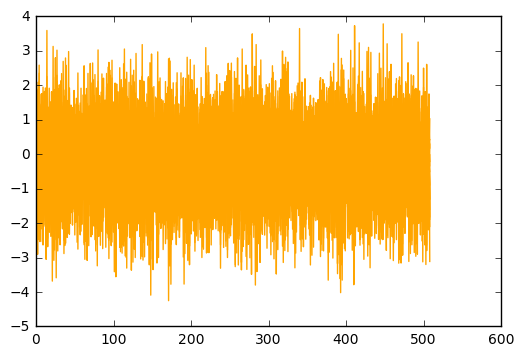

In [5]:
plt.plot(np.arange(seq_length - 1), 
         np.diff(np.asanyarray([get_sample(seq_length, mu_1, sigma_1, rho_1, start_1) 
                        for _ in xrange(batch_size)]).T, axis=0),
         c='blue')
plt.show()
plt.plot(np.arange(seq_length - 1), 
         np.diff(np.asanyarray([get_sample(seq_length, mu_2, sigma_2, rho_2, start_2) 
                        for _ in xrange(batch_size)]).T, axis=0),
         c='orange')
plt.show()

In [6]:
def get_sample_batch(bath_size, seq_length):
    batch_y = np.asarray([np.random.randint(0, 1) for _ in xrange(batch_size)])
    return np.asanyarray(
        [get_sample(seq_length, mu_1, sigma_1, rho_1, start_1) 
         if y == 0 else get_sample(seq_length, mu_1, sigma_1, rho_1, start_1)
         for y in batch_y]
    ), np.asanyarray(
        [[1, 0] if y == 0 else [0, 1] for y in batch_y]
    )

### Filtering/featurizing a time series by convolution

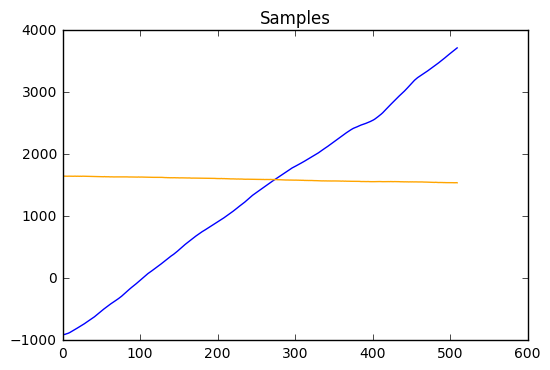

In [7]:
sample_1 = 2500 + get_sample(seq_length, mu_1, sigma_1, rho_1, start_1)
sample_2 = -2500 + get_sample(seq_length, mu_2, sigma_2, rho_2, start_2)

plt.title('Samples')
plt.plot(sample_1, c='blue')
plt.plot(sample_2, c='orange')
plt.show()

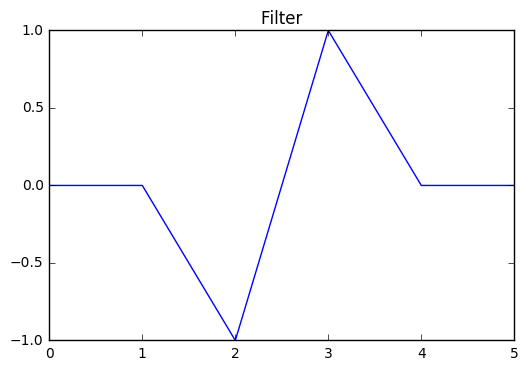

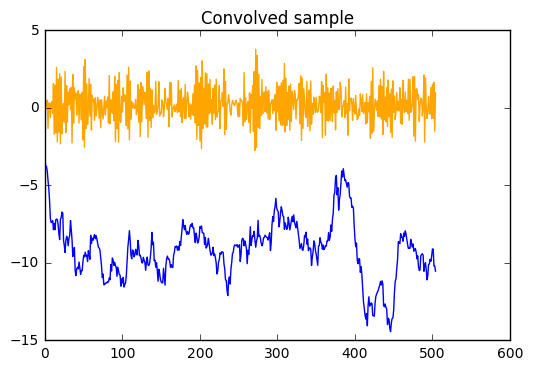

In [8]:
conv_filter = np.asarray([0.0, 0.0, -1.0, 1.0, 0.0, 0.0])

filtered_time_series_1 = np.convolve(sample_1, conv_filter, 'valid')
filtered_time_series_2 = np.convolve(sample_2, conv_filter, 'valid')

plt.title('Filter')
plt.plot(conv_filter)
plt.show()

plt.title('Convolved sample')
plt.plot(filtered_time_series_1, c='blue')
plt.plot(filtered_time_series_2, c='orange')
plt.show()

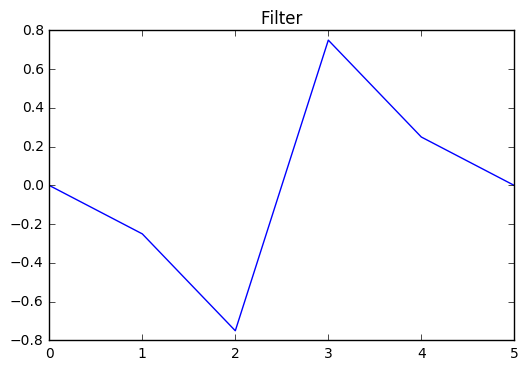

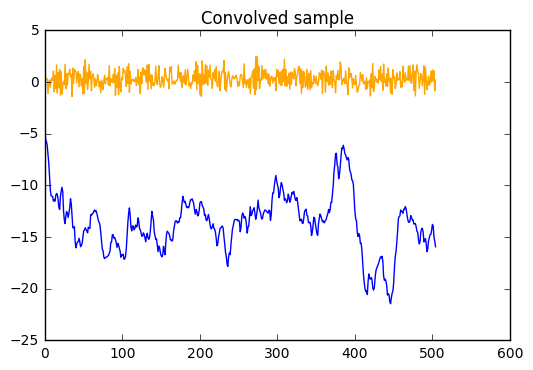

In [9]:
conv_filter = np.asarray([0.0, -0.25, -0.75, 0.75, 0.25, 0.0])

filtered_time_series_1 = np.convolve(sample_1, conv_filter, 'valid')
filtered_time_series_2 = np.convolve(sample_2, conv_filter, 'valid')

plt.title('Filter')
plt.plot(conv_filter)
plt.show()

plt.title('Convolved sample')
plt.plot(filtered_time_series_1, c='blue')
plt.plot(filtered_time_series_2, c='orange')
plt.show()

## Building a convolution network

### Placeholders, where we fit the data

In [10]:
dim_inputs = 1
dim_outputs = 2

x_tf = tf.placeholder("float", [batch_size, seq_length, dim_inputs])
y_tf = tf.placeholder("float", [batch_size, dim_outputs])

### Building our prediction

In [11]:
filter_width = 5
n_dims = 1
n_filters = 16

conv_filter = tf.Variable(tf.random_normal([filter_width,
                                            n_dims,
                                            n_filters]))

feature_1 = tf.nn.conv1d(x_tf, conv_filter, 1, 'VALID')

In [12]:
# Permuting batch_size and n_steps
temp_feature_1 = tf.transpose(feature_1, [1, 0, 2])
# Reshaping to (n_steps*batch_size, dim_filter)
temp_feature_1 = tf.reshape(temp_feature_1, [-1, n_filters])
# Split to get a list of 'n_steps' tensors of shape (batch_size, n_filters)
temp_feature_1 = tf.split(0, seq_length - filter_width + 1, temp_feature_1)

In [13]:
n_hidden = 32
lstm_cell_0 = tf.nn.rnn_cell.BasicLSTMCell(n_hidden, state_is_tuple=True)
outputs, states = tf.nn.rnn(lstm_cell_0, temp_feature_1, dtype=tf.float32)

In [14]:
dim_outputs = 2

weights = tf.Variable(tf.random_normal([n_hidden, dim_outputs]))
biases = tf.Variable(tf.random_normal([dim_outputs]))

logits = tf.matmul(outputs[-1], weights) + biases

### Comparing the prediction to the expected label

In [15]:
to_predict = tf.reshape(y_tf, [-1, dim_outputs])

cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, to_predict))
optimizer = tf.train.AdamOptimizer().minimize(cost)

cost_h = tf.scalar_summary("total_cost", cost)

In [16]:
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(to_predict, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

accuray_h = tf.scalar_summary("accuracy", accuracy)

## Training

In [17]:
summary_dir = '/Users/cusgadmin/CS294/summaries'

train_name = 'train'
train_sub_dir = summary_dir + '/' + train_name
test_name = 'test'
test_sub_dir = summary_dir + '/' + test_name

if train_name not in os.listdir(summary_dir):
    os.mkdir(train_sub_dir)

if test_name not in os.listdir(summary_dir):
    os.mkdir(test_sub_dir)

In [18]:
os.system('tensorboard --logdir=%s --port=6013 &')

0

In [ ]:
training_iters = 100000

with tf.Session() as sess:
    
    summaries = tf.merge_all_summaries()

    train_summary_writer = tf.train.SummaryWriter(train_sub_dir, graph=sess.graph)
    test_summary_writer = tf.train.SummaryWriter(test_sub_dir)
    
    sess.run(tf.initialize_all_variables())
    step = 1

    while step * batch_size < training_iters:
        feed_dict = {}

        # train set
        batch_x, batch_y = get_sample_batch(batch_size, seq_length)
        feed_dict[x_tf] = np.reshape(batch_x, (batch_size, seq_length, dim_inputs))
        feed_dict[y_tf] = batch_y

        sess.run(optimizer, feed_dict=feed_dict)
        
        (loss_eval, summaries_eval) = sess.run((cost, summaries),
                                               feed_dict=feed_dict)

        train_summary_writer.add_summary(summaries_eval, step)
        
        # test set
        batch_x, batch_y = get_sample_batch(batch_size, seq_length)
        feed_dict[x_tf] = np.reshape(batch_x, (batch_size, seq_length, dim_inputs))
        feed_dict[y_tf] = batch_y
        
        (loss_test, summaries_test) = sess.run((cost, summaries),
                                               feed_dict=feed_dict)

        test_summary_writer.add_summary(summaries_test, step)
        
        if step % 5 == 0:
            feature_1_eval, conv_filter_eval = sess.run((feature_1, conv_filter), 
                                                        feed_dict=feed_dict)
            
            plt.title('Filtered data')
            plt.plot(feature_1_eval[0, :, 0])
            plt.show()
                        
            plt.title('Convolution filters')
            plt.plot(conv_filter_eval[:, 0, :])
            plt.show()
            
        print("Iter " + str(step*batch_size) + ", Minibatch Loss= " +
              "{:.6f}".format(loss_eval) + ", Minibatch Test Loss= " + "{:.6f}".format(loss_test))

        step += 1